In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
%matplotlib widget

# USER ENGAGEMENT ANALYSIS (TASK 2)

In the current dataset you’re expected to track the user’s engagement using the following engagement metrics: 
●	sessions frequency 
●	the duration of the session 
●	the sessions total traffic (download and upload (bytes))

Task 2.1 - Based on the above submit python script and slide :
●	Aggregate the above metrics per customer id (MSISDN) and report the top 10 customers per engagement metric 
●	Normalize each engagement metric and run a k-means (k=3) to classify customers into three groups of engagement. 
●	Compute the minimum, maximum, average & total non- normalized metrics for each cluster. Interpret your results visually with accompanying text explaining your findings.
●	Aggregate user total traffic per application and derive the top 10 most engaged users per application
●	Plot the top 3 most used applications using appropriate charts.  
●	Using k-means clustering algorithm, group users in k engagement clusters based on the engagement metrics: 
○	What is the optimized value of k (use elbow method for this)?  
○	Interpret your findings.

In [3]:
if "google.colab" in str(get_ipython()):
    !pip install dvc[gdrive] > /content/piplog.txt
    print(">> g-colab detected \ncloning repo from github\n")
    !git clone https://github.com/JimohAR/it_core_project1

    print("\n>> changing path to the repo\n")
    os.chdir("/content/it_core_project1")

    print("\n>> downloading the datasets\n")
    !dvc import https://github.com/JimohAR/it_core_project1 data/telco.csv \
    -o data/telco.csv

    print("\n>> set up path to the data directory")
    path = os.getcwd() + "/data/"
else:
    print("\n>> set up path to the data directory")
    path = os.path.abspath(os.getcwd() + "/../../data") + "/"


>> set up path to the data directory


In [4]:
def resolve_outlier(df):
    data = df.copy()
    for i in data.select_dtypes(["int", "float"]).keys():
        Q1,Q3 = data[i].quantile([.25,.75])
        IQR = Q3 - Q1
        lower_range = Q1 - (1.5 * IQR)
        upper_range = Q3 + (1.5 * IQR)

        lr_ind = data[i][data[i] < lower_range].keys()
        ur_ind = data[i][data[i] > upper_range].keys()

        data.loc[lr_ind, i] = np.nan
        data.loc[ur_ind, i] = np.nan
        data[i].fillna(data[i].mean(), inplace= True)
    return data

In [5]:
aggregates = pd.read_csv(path + "aggregates.csv", index_col=["MSISDN"])

In [6]:
engagement = aggregates[["tot number of session", "tot sessions duration (hrs)", "tot data usage (MBs)"]]

In [7]:
top10_users_with_high_session_freq = (engagement["tot number of session"]
                                      .sort_values(ascending = False).to_frame()
                                      .head(10)
                                     )

top10_users_with_high_sessions_duration = (engagement["tot sessions duration (hrs)"]
                                      .sort_values(ascending = False).to_frame()
                                      .head(10)
                                     )

top10_users_with_high_data_usage = (engagement["tot data usage (MBs)"]
                                      .sort_values(ascending = False).to_frame()
                                      .head(10)
                                     )

In [8]:
top10_users_with_high_data_usage

,tot data usage (MBs)
MSISDN,
33650426463,4860.047088
33666169635,4550.902257
33665354456,4387.362709
33699904865,4270.838906
33665550456,4177.437149
33699382524,4070.142609
33763573482,4041.040859
33661622844,4017.970123
33658849197,3979.991702


In [9]:
scaler = StandardScaler()

In [10]:
agg_scaled = pd.DataFrame(scaler.fit_transform(resolve_outlier(aggregates)), columns= aggregates.columns)

In [11]:
kmeans = KMeans(n_clusters=3, random_state=0)

In [12]:
kmeans.fit(agg_scaled)

KMeans(n_clusters=3, random_state=0)

In [13]:
agg_plus_cluster = aggregates.copy()
agg_plus_cluster["label"] = kmeans.labels_

In [14]:
task2_cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns = aggregates.columns)

In [15]:
mapper = dict(zip(task2_cluster_centers["tot data usage (MBs)"].sort_values().keys(), ["little engagement", "medium engagement", "large engagement"]))

In [16]:
task2_cluster_centers = task2_cluster_centers.rename(index = mapper).rename_axis("labels")
task2_cluster_centers.to_csv(path + "user_engagement_cluster_centers.csv")

In [17]:
agg_plus_cluster["label"] = agg_plus_cluster["label"].map(mapper)

### Compute the minimum, maximum, average & total non- normalized metrics for each cluster. Interpret your results visually with accompanying text explaining your findings.

In [18]:
agg_plus_cluster.groupby("label").min().T.style

label,large engagement,little engagement,medium engagement
tot number of session,1.000000,1.000000,1.000000
tot sessions duration (hrs),5.065278,1.996944,1.983889
social media data usage (MBs),0.059015,0.001491,0.004262
google data usage (MBs),1.284316,0.038462,0.112669
Email data usage (MBs),0.191657,0.017334,0.030950
youtube data usage (MBs),3.423847,0.075248,0.150152
netflix data usage (MBs),3.375638,0.237110,0.176019
gaming apps data usage (MBs),26.171268,0.292166,336.023965
other apps data usage (MBs),14.440469,0.488061,0.142140
tot downloaded data (MBs),62.247034,8.418161,407.187532


In [19]:
agg_plus_cluster.groupby("label").max().T.style

label,large engagement,little engagement,medium engagement
tot number of session,5.000000,4.000000,11.000000
tot sessions duration (hrs),347.586389,327.088056,359.504444
social media data usage (MBs),12.980293,6.783621,22.698244
google data usage (MBs),50.450966,29.082510,83.574781
Email data usage (MBs),14.724834,7.764979,21.861470
youtube data usage (MBs),152.671731,73.319009,237.480580
netflix data usage (MBs),139.875628,83.048364,222.896995
gaming apps data usage (MBs),3043.169817,443.752156,4343.421737
other apps data usage (MBs),3115.962507,1887.022923,4392.022408
tot downloaded data (MBs),3130.052783,456.444612,4545.041459


In [20]:
agg_plus_cluster.groupby("label").mean().T.style

label,large engagement,little engagement,medium engagement
tot number of session,2.217118,1.006944,1.203842
tot sessions duration (hrs),60.618811,28.729611,34.907345
social media data usage (MBs),3.873011,1.741421,2.108304
google data usage (MBs),16.505717,7.436863,9.018213
Email data usage (MBs),4.762914,2.163048,2.607499
youtube data usage (MBs),47.847608,21.578660,26.158026
netflix data usage (MBs),48.000755,21.542674,26.049761
gaming apps data usage (MBs),908.664341,209.110799,685.484020
other apps data usage (MBs),908.108447,410.002273,495.177519
tot downloaded data (MBs),960.034678,232.235446,713.601782


In [21]:
agg_plus_cluster.groupby("label").count().T.iloc[0]

label
large engagement     26078
little engagement    38880
medium engagement    41596
Name: tot number of session, dtype: int64

''

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
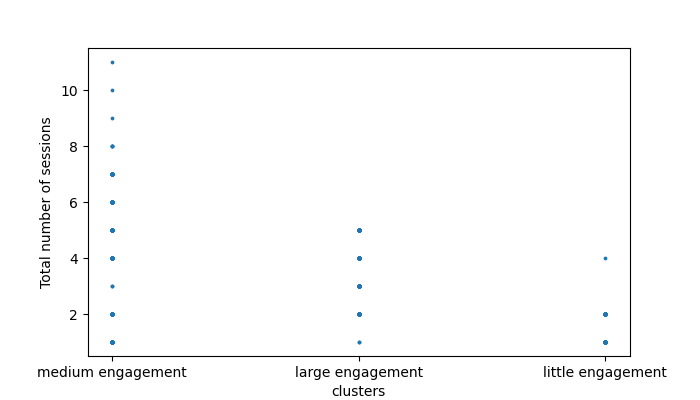

In [22]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.scatter(agg_plus_cluster["label"], agg_plus_cluster["tot number of session"], s=3)
plt.xlabel("clusters")
plt.ylabel("Total number of sessions")
;

###  ● Aggregate user total traffic per application and derive the top 10 most engaged users per application ● Plot the top 3 most used applications using appropriate charts.

In [23]:
app_cols = ['social media data usage (MBs)', 'google data usage (MBs)',
       'Email data usage (MBs)', 'youtube data usage (MBs)',
       'netflix data usage (MBs)', 'gaming apps data usage (MBs)',
       ]
largest_10_entries_per_metric = pd.DataFrame()
for i in app_cols:
    largest_10_entries_per_metric[i] = aggregates[i].sort_values(ascending= False).head(10).tolist()

In [24]:
largest_10_entries_per_metric

,social media data usage (MBs),google data usage (MBs),Email data usage (MBs),youtube data usage (MBs),netflix data usage (MBs),gaming apps data usage (MBs)
0,22.698244,83.574781,21.861470,237.480580,222.896995,4343.421737
1,18.186049,75.072834,20.907565,226.046673,202.187567,4050.096912
2,17.218717,74.219402,20.026962,225.451283,197.875129,3993.737237
3,17.149566,68.766560,19.655470,191.224544,195.816385,3919.795651
4,15.816863,68.640566,19.284823,183.959473,192.058394,3790.729834
5,15.753781,66.362096,18.671650,181.911520,190.238172,3647.933038
6,15.429578,66.128575,18.587090,180.657377,186.781820,3603.136848
7,15.359530,64.254685,18.344635,179.941454,184.438187,3571.500108
8,15.227897,62.406015,18.168324,179.292764,184.264451,3561.990721
9,14.992252,62.305976,17.984228,178.700468,181.814404,3540.684531


### ● Plot the top 3 most used applications using appropriate charts.

we assume that the total amount of data used is prortional to how much the app is used. This may not be totally accurate but that's the best we can deduce from this data

In [25]:
top3_most_used_apps = aggregates[app_cols].sum().sort_values(ascending=False).head(3)

In [26]:
# convert MB to GB
top3_most_used_apps = top3_most_used_apps/1024 

In [27]:
top3_most_used_apps.columns = ["gaming apps data usage (GBs)", "youtube data usage (GBs)", "netflix data usage (GBs)"]

Text(0, 0.5, 'App total data usage (GBs)')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
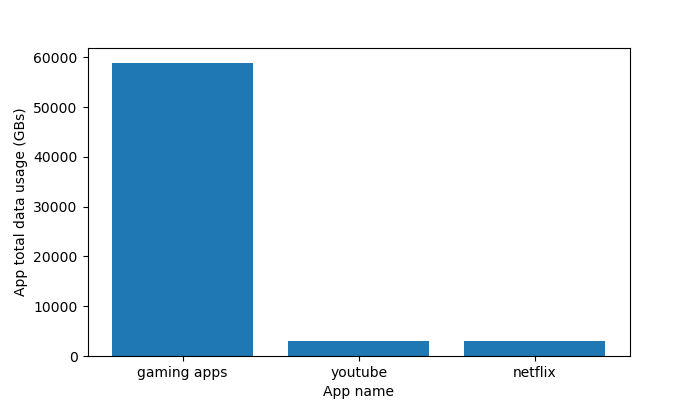

In [28]:
fig2, ax2 = plt.subplots(1,1, figsize=(7,4))
ax2.bar([i.split(" data")[0] for i in top3_most_used_apps.columns], top3_most_used_apps)
plt.xlabel("App name")
plt.ylabel("App total data usage (GBs)")

In [29]:
%matplotlib inline

### Using k-means clustering algorithm, group users in k engagement clusters based on the engagement metrics: ○ What is the optimized value of k (use elbow method for this)?

In [30]:
kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 42,
    }
   
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(agg_scaled)
    sse.append(kmeans.inertia_)

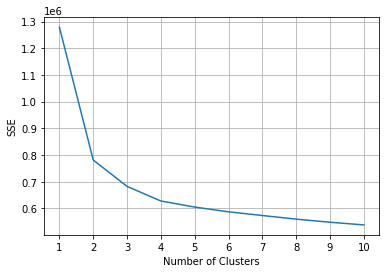

In [31]:
# plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.grid(True)
#plt.show()

### ○ Interpret your findings.